In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
df_congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv")

In [4]:
df_congress.head()

,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
0,0,H4LA05221,ralph abraham,Rep.,Abraham,Ralph,R,1954-09-16,M,LA
1,1,H4NC12100,alma adams,Rep.,Adams,Alma,D,1946-05-27,F,NC
2,2,H6AL04098,robert aderholt,Rep.,Aderholt,Robert,R,1965-07-22,M,AL
3,3,H2CA31125,pete aguilar,Rep.,Aguilar,Pete,D,1979-06-19,M,CA
4,4,H2GA12121,rick allen,Rep.,Allen,Rick,R,1951-11-07,M,GA


In [5]:
%%time 
# link to the Drive repo + the year of the newpapers quotes
path_to_file = '/content/drive/MyDrive/ADA/quotes-2017-congress-speakers.json.bz2'
# here the data is in the ADA folder placed at the root of your Drive

df_quotes_2017 = []
with bz2.open(path_to_file, 'rb') as s_file:
    for i, sample in enumerate(s_file):
      quote = json.loads(sample)
      df_quotes_2017.append(quote)

CPU times: user 23.5 s, sys: 800 ms, total: 24.3 s
Wall time: 24.3 s


In [6]:
# Transforming the array of quotes in a pandas DataFrame
df_quotes_2017 = pd.DataFrame(df_quotes_2017)
df_quotes_2017.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2017-10-31-000480,[ Opioid abuse ] is straining the resources of...,Bob Casey,[Q2907612],2017-10-31 19:58:24,1,"[[Bob Casey, 0.5118], [None, 0.3882], [Preside...",[http://thedailybeast.com/two-critical-republi...,E
1,2017-10-31-000757,... was into Elliott's rear bumper 100 feet be...,Rick Allen,"[Q16226019, Q30122355, Q323356, Q7331191]",2017-10-31 05:11:43,1,"[[Rick Allen, 0.7902], [Denny Hamlin, 0.1182],...",[https://www.frontstretch.com/2017/10/31/couch...,E
2,2017-07-26-084102,Jeff Sessions is one of the most decent people...,Lindsey Graham,[Q22212],2017-07-26 16:56:24,1,"[[Lindsey Graham, 0.933], [None, 0.0338], [Ric...",[http://news.vice.com/story/trump-actually-has...,E
3,2017-06-15-000974,50 Years of Breaking Barriers and Building Fut...,Maxine Waters,[Q461727],2017-06-15 00:00:57,1,"[[Maxine Waters, 0.8347], [None, 0.1653]]",[https://lasentinel.net/rep-waters-delivers-ke...,E
4,2017-07-28-001488,A disappointment indeed... Our friends on the ...,Mitch McConnell,[Q355522],2017-07-28 16:00:08,1,"[[Mitch McConnell, 0.6749], [None, 0.2717], [C...",[http://www.opposingviews.com/i/society/reacti...,E


In [7]:
# Upload the attributes of the speakers
df_attributes = pd.read_parquet("/content/drive/MyDrive/Project_datasets/speaker_attributes.parquet")
df_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [8]:
# Merge the congress dataframe with the quotes dataframe

# Just a check of the number of different political parties 
print(df_congress.party.unique())
rep = df_congress[df_congress.party == 'R']
sen = df_congress[df_congress.party == 'D']
ind = df_congress[df_congress.party == 'ID']
print(f'Rep: {rep.shape[0]}')   
print(f'Sen: {sen.shape[0]}')
print(f'Ind: {ind.shape[0]}') 

# Then create a new dataframe df with the political affiliation of speaker
df = df_quotes_2017
df['speaker'] = df['speaker'].str.lower() #puts all strings in lower cases
df_congress_new = df_congress[['party','speaker','date_of_birth','gender','state']].copy()
df = df.merge(df_congress_new, how = 'left', on='speaker')
df

['R' 'D' 'ID']
Rep: 188
Sen: 198
Ind: 1


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,date_of_birth,gender,state
0,2017-10-31-000480,[ Opioid abuse ] is straining the resources of...,bob casey,[Q2907612],2017-10-31 19:58:24,1,"[[Bob Casey, 0.5118], [None, 0.3882], [Preside...",[http://thedailybeast.com/two-critical-republi...,E,D,1960-04-13,M,PA
1,2017-10-31-000757,... was into Elliott's rear bumper 100 feet be...,rick allen,"[Q16226019, Q30122355, Q323356, Q7331191]",2017-10-31 05:11:43,1,"[[Rick Allen, 0.7902], [Denny Hamlin, 0.1182],...",[https://www.frontstretch.com/2017/10/31/couch...,E,R,1951-11-07,M,GA
2,2017-07-26-084102,Jeff Sessions is one of the most decent people...,lindsey graham,[Q22212],2017-07-26 16:56:24,1,"[[Lindsey Graham, 0.933], [None, 0.0338], [Ric...",[http://news.vice.com/story/trump-actually-has...,E,R,1955-07-09,M,SC
3,2017-06-15-000974,50 Years of Breaking Barriers and Building Fut...,maxine waters,[Q461727],2017-06-15 00:00:57,1,"[[Maxine Waters, 0.8347], [None, 0.1653]]",[https://lasentinel.net/rep-waters-delivers-ke...,E,D,1938-08-15,F,CA
4,2017-07-28-001488,A disappointment indeed... Our friends on the ...,mitch mcconnell,[Q355522],2017-07-28 16:00:08,1,"[[Mitch McConnell, 0.6749], [None, 0.2717], [C...",[http://www.opposingviews.com/i/society/reacti...,E,R,1942-02-20,M,KY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313107,2017-05-31-065235,It is vital that they play a significant role ...,steve king,"[Q37084447, Q749710, Q7613030, Q7613031, Q7613...",2017-05-31 07:38:06,2,"[[Steve King, 0.8731], [None, 0.115], [Scott R...",[http://www.campaignlive.co.uk/article/publici...,E,R,1949-05-28,M,IA
313108,2017-03-02-047914,It was so invigorating to see so many people s...,salud carbajal,[Q27805429],2017-03-02 08:47:46,1,"[[Salud Carbajal, 0.9296], [None, 0.0674], [Pr...",[http://www.santamariasun.com/news/15780/centr...,E,D,1964-11-18,M,CA
313109,2017-05-23-059544,It would gut critical services and programs se...,nita lowey,[Q460652],2017-05-23 19:23:27,2,"[[Nita Lowey, 0.7933], [None, 0.2067]]",[https://patch.com/new-york/bedford/2018-feder...,E,D,1937-07-05,F,NY
313110,2017-06-18-033843,its actions to undermine U.S. allies and inter...,rob portman,[Q926069],2017-06-18 02:25:18,1,"[[Rob Portman, 0.7681], [None, 0.2319]]",[http://limaohio.com/news/249093/legislative-u...,E,R,1955-12-19,M,OH


In [9]:
# Merge attributes dataframe with the quotes dataframe containing also political parties
df_attributes['label'] = df_attributes['label'].str.lower()
df_all = df.merge(df_attributes, how='left', left_on='speaker', right_on='label', indicator=True)
df_all.head() #-> duplicates? to be solved for ML3, for now we will use df

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party_x,date_of_birth_x,gender_x,state,aliases,date_of_birth_y,nationality,gender_y,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party_y,academic_degree,id,label,candidacy,type,religion,_merge
0,2017-10-31-000480,[ Opioid abuse ] is straining the resources of...,bob casey,[Q2907612],2017-10-31 19:58:24,1,"[[Bob Casey, 0.5118], [None, 0.3882], [Preside...",[http://thedailybeast.com/two-critical-republi...,E,D,1960-04-13,M,PA,None,[+1909-02-11T00:00:00Z],[Q30],[Q6581097],1.311344e+09,None,None,[Q6168364],None,None,Q47541467,bob casey,None,item,None,both
1,2017-10-31-000480,[ Opioid abuse ] is straining the resources of...,bob casey,[Q2907612],2017-10-31 19:58:24,1,"[[Bob Casey, 0.5118], [None, 0.3882], [Preside...",[http://thedailybeast.com/two-critical-republi...,E,D,1960-04-13,M,PA,[Robert Casey],[+1978-07-18T00:00:00Z],[Q27],[Q6581097],1.330080e+09,None,None,[Q14089670],None,None,Q2907612,bob casey,None,item,None,both
2,2017-10-31-000480,[ Opioid abuse ] is straining the resources of...,bob casey,[Q2907612],2017-10-31 19:58:24,1,"[[Bob Casey, 0.5118], [None, 0.3882], [Preside...",[http://thedailybeast.com/two-critical-republi...,E,D,1960-04-13,M,PA,None,[+1859-01-26T00:00:00Z],[Q30],[Q6581097],1.315023e+09,None,None,[Q10871364],None,None,Q4932030,bob casey,None,item,None,both
3,2017-10-31-000480,[ Opioid abuse ] is straining the resources of...,bob casey,[Q2907612],2017-10-31 19:58:24,1,"[[Bob Casey, 0.5118], [None, 0.3882], [Preside...",[http://thedailybeast.com/two-critical-republi...,E,D,1960-04-13,M,PA,None,[+1925-04-11T00:00:00Z],[Q30],[Q6581097],1.315024e+09,None,None,[Q1371925],None,None,Q4932029,bob casey,None,item,None,both
4,2017-10-31-000757,... was into Elliott's rear bumper 100 feet be...,rick allen,"[Q16226019, Q30122355, Q323356, Q7331191]",2017-10-31 05:11:43,1,"[[Rick Allen, 0.7902], [Denny Hamlin, 0.1182],...",[https://www.frontstretch.com/2017/10/31/couch...,E,R,1951-11-07,M,GA,None,[+1969-06-17T00:00:00Z],[Q30],[Q6581097],1.312930e+09,None,None,[Q13219447],None,None,Q16226019,rick allen,None,item,None,both


In [10]:
subject = 'climate'
env_quote = []
index = []
for i in range(df.shape[0]):
    if df.quotation[i].find(subject) > 0:
        env_quote.append(df.quotation[i])
        index.append(i)

print(f"Number of quotes containing the word \'{subject}\' is {len(env_quote)}")
df_climate = df.iloc[index]
df_climate.head()

Number of quotes containing the word 'climate' is 1020


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,date_of_birth,gender,state
13,2017-06-02-078684,My hope is that with the president's decision ...,lisa murkowski,[Q22360],2017-06-02 02:38:19,1,"[[Lisa Murkowski, 0.7365], [None, 0.2635]]",[http://juneauempire.com/news/2017-06-01/junea...,E,R,1957-05-22,F,AK
620,2017-08-16-089882,Louisiana flood victims are already struggling...,ralph abraham,"[Q18683775, Q973595]",2017-08-16 14:26:06,1,"[[Ralph Abraham, 0.8851], [None, 0.1118], [Pre...",[https://insurancenewsnet.com/oarticle/abraham...,E,R,1954-09-16,M,LA
708,2017-07-18-115705,This vote is proof that there is now a biparti...,ted deutch,[Q245724],2017-07-18 08:00:00,2,"[[Ted Deutch, 0.9429], [None, 0.0521], [Bob Go...",[http://newsadvance.com/opinion/letters_to_edi...,E,D,1966-05-07,M,FL
778,2017-08-23-097946,Our business climate is one that we're trying ...,mike johnson,"[Q1137104, Q1176984, Q1391901, Q16106677, Q165...",2017-08-23 01:23:00,1,"[[Mike Johnson, 0.8135], [None, 0.179], [Ollie...",[http://kpvi.com/news/national_news/k-grant-fo...,E,R,1972-01-30,M,LA
786,2017-05-01-076116,President Trump named climate change denier Sc...,nita lowey,[Q460652],2017-05-01 00:00:00,1,"[[Nita Lowey, 0.5679], [None, 0.4321]]",[http://wamc.org/post/ny-congresswoman-stands-...,E,D,1937-07-05,F,NY


# Research question 1 : Analysis of the positivity and negativity of each quote related to climate change
(Note: We are aware that the importation should be done at the beginning of the notebook but considering that for ML3 the 3 research questions will be in different notebooks we chose to import the packages here)

In [11]:
# Use natural language toolkit analyser was used
import nltk 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

temp_compound = []
toscore = df_climate['quotation'].str.lower().tolist()


for i in range(len(toscore)):
  temp_compound += [SentimentIntensityAnalyzer().polarity_scores(toscore[i]).get('compound')]

df_climate['sentiment_score'] = temp_compound

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


# Research question 2: Which major attributes of politicians can explain his/her opinion on a precise issue?

In [12]:
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Note that for ML2 we only used date of birth and gender from the congress df to ease the initial analysis
# For ML3, more attributes (especially from speaker_attributes data) will be considered

# Convert date of birth to age
now = pd.Timestamp('now')
df_climate['date_of_birth'] = pd.to_datetime(df_climate['date_of_birth']) #convert dob to date
df_climate['age'] = (now - df_climate['date_of_birth']).astype('<m8[Y]')

# Declares the model
mod = smf.ols(formula='sentiment_score ~ age + gender', data=df_climate)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.947
Date:                Thu, 11 Nov 2021   Prob (F-statistic):             0.0196
Time:                        21:32:55   Log-Likelihood:                -802.11
No. Observations:                1017   AIC:                             1610.
Df Residuals:                    1014   BIC:                             1625.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1351      0.105      1.290      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Note that here, the age and the gender only do not explain the positivity or negativity of a quote at all.

# Research question 3: examples of interesting fact to present and study 
This types of analysis should be done for each year to study the temporal evolution

[]

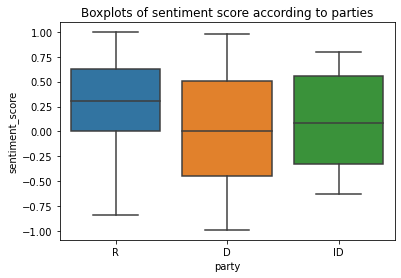

In [13]:
# BOXPLOT with sentiment score for each party
ax = sns.boxplot(x="party", y="sentiment_score", data=df_climate)
ax.set_title('Boxplots of sentiment score according to parties')
plt.plot() 

In [14]:
count_total_quotes = [df.party.value_counts()['R'], df.party.value_counts()['D'], df.party.value_counts()['ID']] 
#df.party.value_counts()['R'] much faster than df[df['party]=='R'].sum()

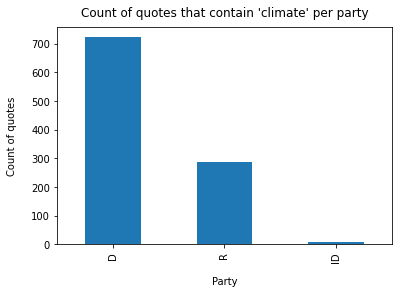

In [15]:
#BARPLOT with counts of climate quotes over total quotes for each party 
df_climate['party'].value_counts().plot(kind='bar');
plt.xlabel("Party", labelpad=14)
plt.ylabel("Count of quotes", labelpad=14)
plt.title("Count of quotes that contain 'climate' per party", y=1.02);

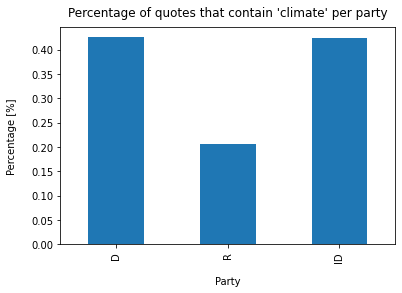

In [16]:
#BARPLOT with percentage of climate quotes for each party 
ratio_data = df_climate['party'].value_counts()/count_total_quotes*100
ratio_data.plot(kind='bar');
plt.xlabel("Party", labelpad=14)
plt.ylabel("Percentage [%]", labelpad=14)
plt.title("Percentage of quotes that contain 'climate' per party", y=1.02);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Statistics for quotes that contain 'climate'
count    1020.000000
mean      222.854902
std       191.798954
min        30.000000
25%       108.750000
50%       172.500000
75%       269.250000
max      2195.000000
Name: quote_length, dtype: float64

Statistics for all quotes
count    313112.000000
mean        136.779986
std         112.574738
min           9.000000
25%          64.000000
50%         109.000000
75%         174.000000
max        2678.000000
Name: quote_length, dtype: float64


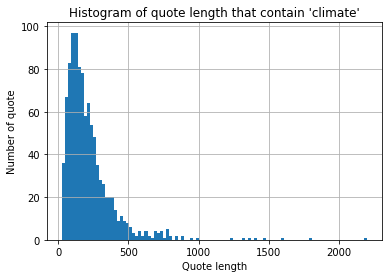

In [17]:
#BOXPLOT Average length of quotes containing climate compared to average total length 
df_climate['quote_length']=df_climate.quotation.str.len()
df['quote_length']=df.quotation.str.len()

df_climate['quote_length'].hist(bins = 100)
plt.xlabel('Quote length')
plt.ylabel('Number of quote')
plt.title("Histogram of quote length that contain 'climate'")

print("Statistics for quotes that contain 'climate'")
print(df_climate['quote_length'].describe())
print("\nStatistics for all quotes")
print(df['quote_length'].describe())

Quotes that contain the word 'climate' seem to be longer than the average quote (see quartile 75). Is it because climate change is a complex subject that tends to make politicians explain their opinion in more details? To be explored...

# Additional analysis

In [18]:
# Check the most common qids
df.qids.to_list

test = df.explode('qids').reset_index(drop=True)
test.qids.value_counts()

# Note: QIDs seem to be only political figures????

Q355522      9783
Q170581      9489
Q22212       9191
Q434706      5938
Q324546      5538
             ... 
Q16966491       1
Q11318970       1
Q14249324       1
Q57314959       1
Q56635322       1
Name: qids, Length: 909, dtype: int64